<a href="https://colab.research.google.com/github/ankuu63/week_1-2-task/blob/main/Aicte_ImageClassification_Internship.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**E WASTE CLASSIFICATION using EfficientNetV2B0_Transfer Learning**


1. DATASET uploaded and Unzipped




In [2]:
import zipfile
zip_ref= zipfile.ZipFile('/content/E-Waste classification dataset (1) (1).zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

2. Import REQUIRED  LIBRARIES


In [3]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix

from PIL import Image

3. DIRECTORY_SETUP

In [4]:
trainpath='/content/modified-dataset/train'
testpath='/content/modified-dataset/train'
validatepath='/content/modified-dataset/val'

4. UNDERSTANDING DATA

* Split data into training, validation, and testing sets.
* BATCH FORMATION AND SPECIFING PATH
   



In [5]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [6]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [7]:
datavalidate=tf.keras.utils.image_dataset_from_directory(validatepath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


classes in Traindatset

In [8]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


5. DAta analysis

* EDA : exploitary data analysis
* VISUALIZING SAMPLE IMAGES
* Preprocessing : Image Reshape,Image  Augmentation

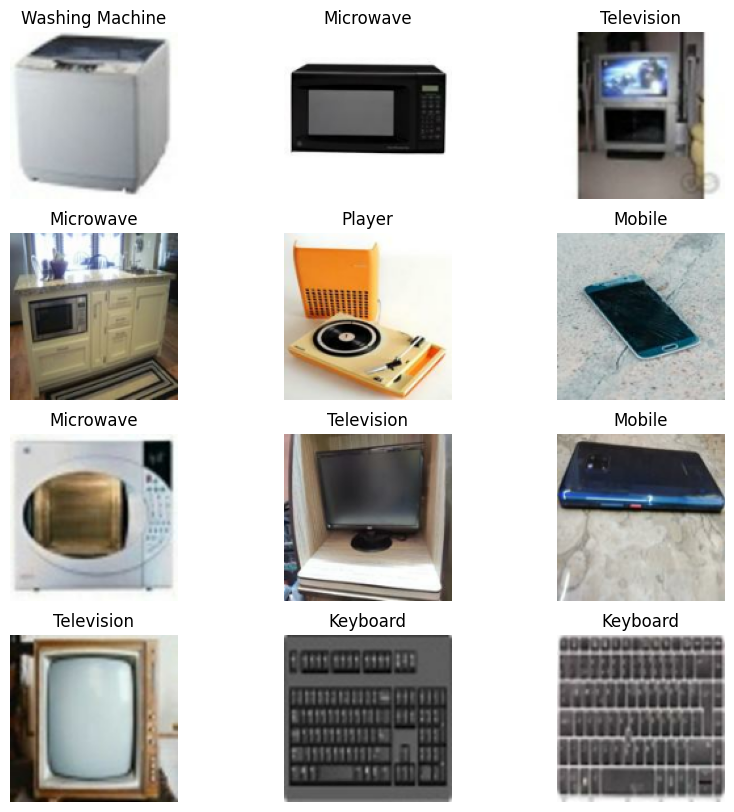

In [9]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [10]:
def plot_class_distribution(dataset, title="Class Distribution"):
    class_counts = {}  # Define dict

    # Fill counts
    for images, labels in dataset:
        for label in labels.numpy():
            class_name = dataset.class_names[label]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Prepare data for plotting (must be inside function!)
    class_name = list(class_counts.keys())
    counts = list(class_counts.values())

    # Create the bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(class_name, counts)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()

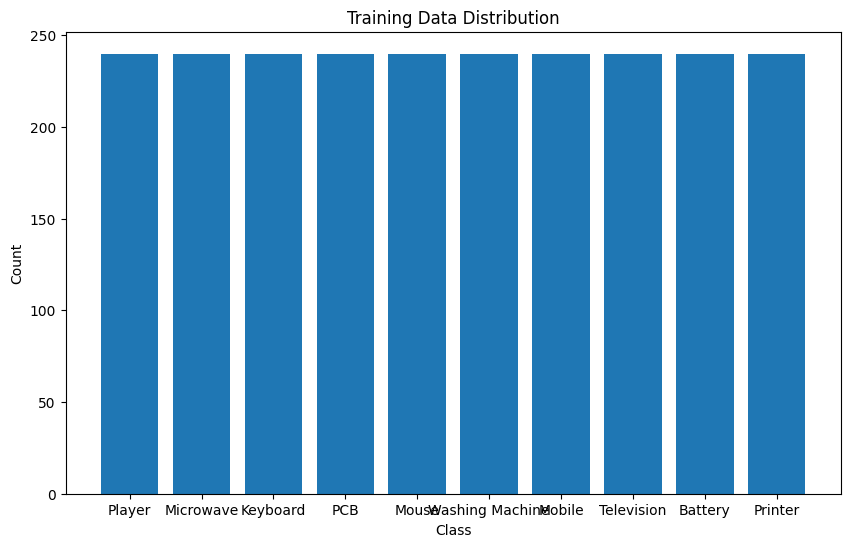

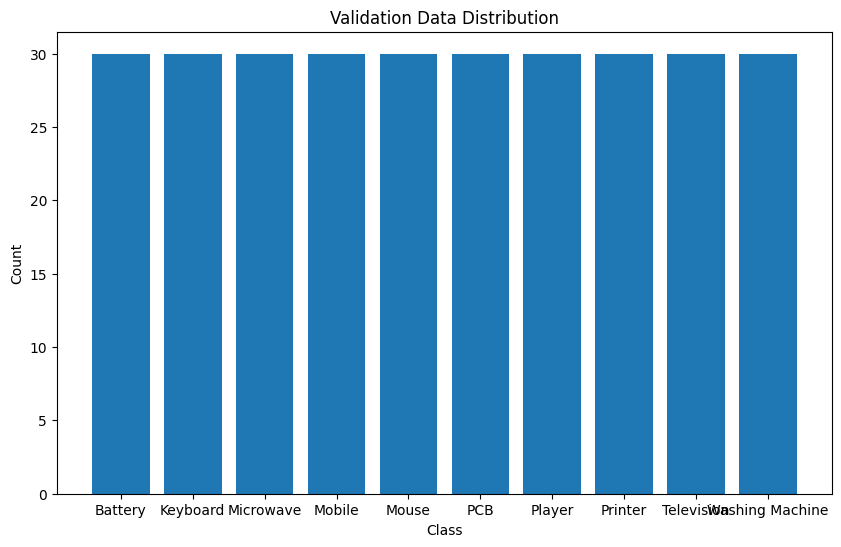

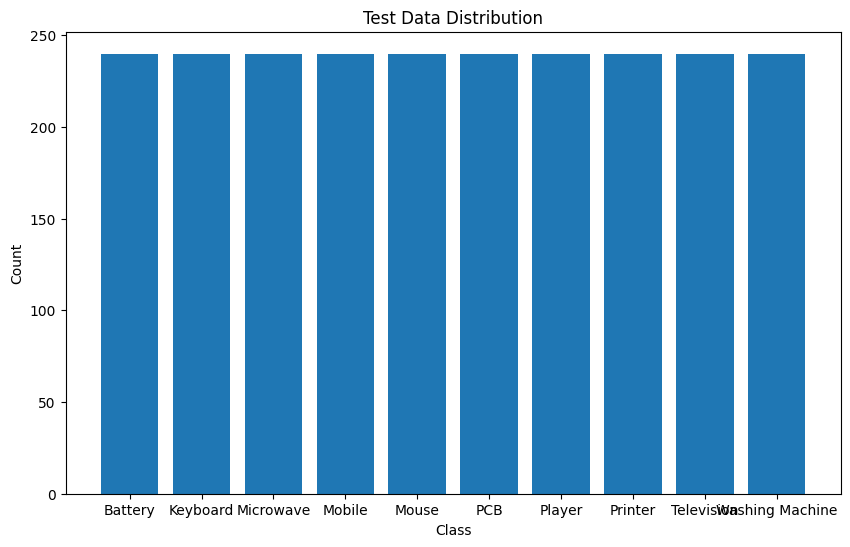

In [11]:
plot_class_distribution(datatrain, "Training Data Distribution")
plot_class_distribution(datavalidate, "Validation Data Distribution")
plot_class_distribution(datatest, "Test Data Distribution")

IMAGESET AUGMENTATION


In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

6. **EfficientNetV2B0 as MOdel**

In [13]:
model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
model.trainable = True
for layer in model.layers[:100]:
    layer.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step




*  Configuiring the Model and Compilation


In [14]:
modelE = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])


In [15]:
modelE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [18]:
modelE.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,269,040 (62.06 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

 Optimizer params: 10,336,918 (39.43 MB)

* Early_Stopping






In [16]:
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Monitor to validation_loss
    patience=3,
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

7. **Training with 8 epoch, 100 as batchsize**

In [17]:
history = modelE.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalidate,      # Validation data generator or dataset
    epochs=15 ,
    batch_size=100,
    callbacks=[early]               # List of callbacks to apply earlystopping
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - Accuracy: 0.2725 - loss: 2.1202 - val_Accuracy: 0.7933 - val_loss: 1.1160
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - Accuracy: 0.7752 - loss: 1.0050 - val_Accuracy: 0.8967 - val_loss: 0.5210
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - Accuracy: 0.8669 - loss: 0.5190 - val_Accuracy: 0.9300 - val_loss: 0.3152
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - Accuracy: 0.9069 - loss: 0.3576 - val_Accuracy: 0.9500 - val_loss: 0.2431
Epoch 5/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - Accuracy: 0.9344 - loss: 0.2742 - val_Accuracy: 0.9567 - val_loss: 0.2080
Epoch 6/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - Accuracy: 0.9380 - loss: 0.2212 - val_Accuracy: 0.9600 - val_loss: 0.1819
Epoch 7/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - Accuracy: 0.9521 - loss: 0.1616 - val_Accuracy: 0.9600 - val_loss: 0.1616
Epoch 8/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - Accuracy: 0.9685 - loss: 0.1354 - val_Accuracy: 0.9567 - v

Result_Prediction and Plotting ConfusionMatrix_heatmap

75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 633ms/step


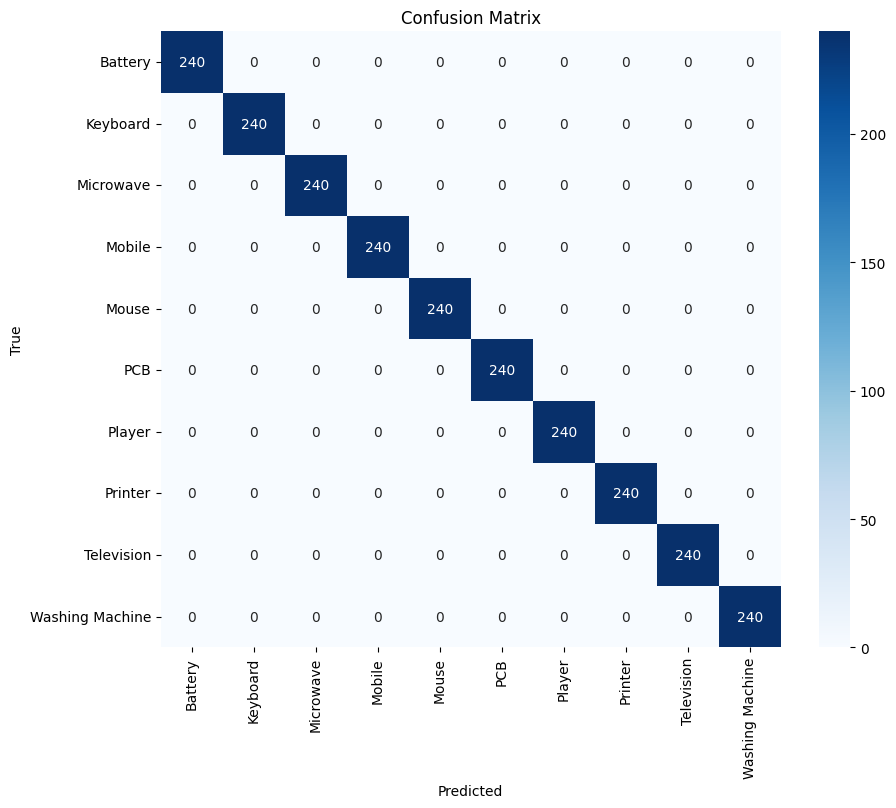

In [20]:
result=modelE.predict(datatest)


# Class with highest probability
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels
y_pred = np.argmax(result, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))                         # figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                            # Create heatmap with class labels

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Training and validation accuraccy analysis

In [21]:
### Plotting Training and Validation Accuracy and Loss Over Epochs

acc = history.history['Accuracy']           # Training accuracy
val_acc = history.history['val_Accuracy']   # Validation accuracy
loss = history.history['loss']              # Training loss
val_loss = history.history['val_loss']      # Validation loss

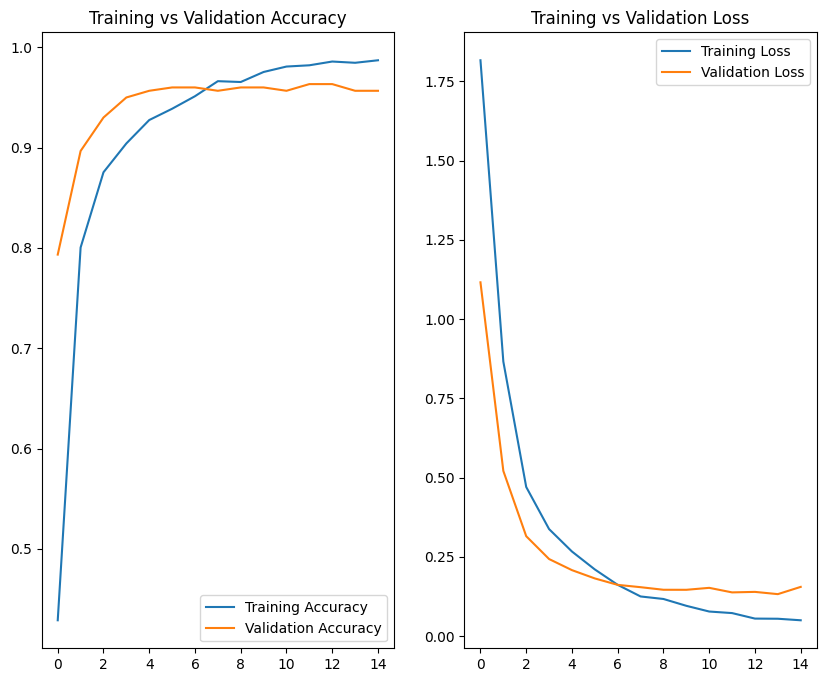

In [22]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()

Saving model and Deployment

In [ ]:
class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()

In [ ]:
model.save('Efficient_classify.keras')

# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

In [68]:
!pip install gradio

Gradio interface and proccesing

In [ ]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

In [ ]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)


iface.launch()